<a href="https://colab.research.google.com/github/BrainsCorp/Data-Science-Stuff/blob/master/Query_Classifer_Retrieval_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROBLEM STATEMENT
Query Classification is the Typical Problem in RAG Based Soluton<br> Citation:
['Best Practices for RAG Retrieval Augmentation Generation'](https://arxiv.org/pdf/2407.01219)

1. Not All Queries Require RAG due to inherent capabilities of LLM’s that have been trained on vast amount of WEB corpus.
1. One of the Best Practices before Retriving Documents is to Classifying Queries for neccessity of retrieval.

## Example
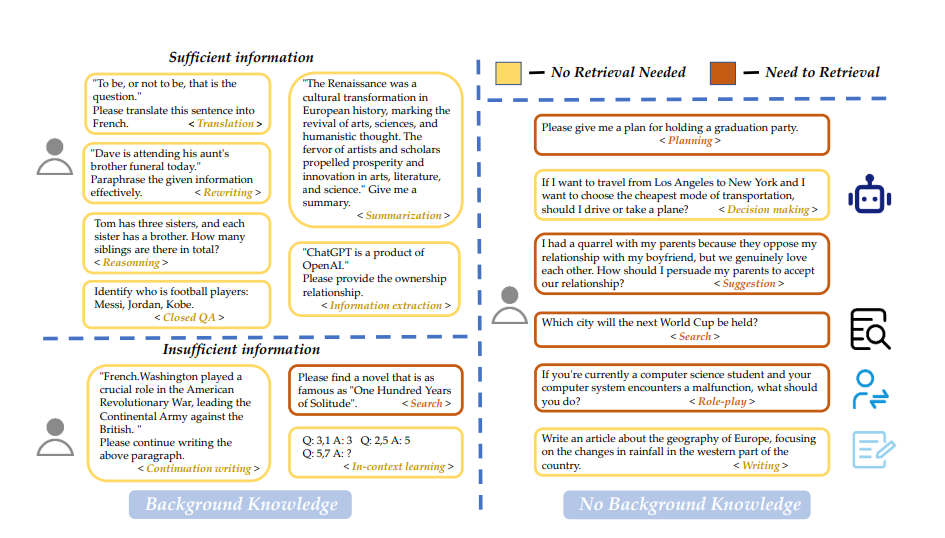

## Solution.
1. Prepare a Dataset of User Query that our chatbot needs to answer
  1. Query Identification - ```<search>``` tag queries which our chatbot needs to address.
  1. Collect Relevant Sample of Queries that our system will be facing.
  1. Replicate these samples using LLMs (OpenAI - GPT Models) ✨
1. Preprocess Data
  1. TF-idf Vectorization and Techinques (Lemmatization, Stopwords)
1. Build a Machine Learning Model
  1. Test using Traditional Classification Models
  1. SVC, Random Forests, XGBoost Classifier, Multinomial NB

## Load Neccessary Libraries
1. NLTK package
2. Sklearn - Classifying models and TD-IDF vector
3. XGBoost - Classifier
4. Ploting Libraries - Matplotlib and Seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
dash_line = '-'*30

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

#sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

#XGBoost
import xgboost as xgb

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Load Dataset
1. User Query Dataset 1 - 6000 samples
2. User Query Dataset 2 - 3000 samples

## Dataset Generation Source
1. Sample Types of User Queries ```[<search>]```
2. Use of LLMs to replicated the samples

In [ ]:
#load dataset
df = pd.read_csv('user_queries_rag.csv', header='infer')
df_2 = pd.read_excel('user_queries_rag_2.xlsx')
print("Dataset 1: ", df.shape)
display(df.head())

print("Dataset 2: ", df_2.shape)
display(df_2.head())

Dataset 1:  (6000, 3)


,ID,query,label
0,1,What is the best way to study business managem...,1
1,2,What are the prerequisites for finance?,1
2,3,What are the latest news headlines?,0
3,4,What courses are available for learning hospit...,1
4,5,What are the latest news headlines?,0


Dataset 2:  (3107, 2)


,query,label
0,Who are you? Tell me about yourself,0
1,What programming languages are covered in the ...,1
2,The old grandfather clock in the hallway chime...,0
3,How can we integrate more hands-on projects in...,1
4,She couldn't decide between chocolate and vani...,0


In [ ]:
#reset index with ID
df.set_index(keys='ID', inplace=True)
df.head()

,query,label
ID,,
1,What is the best way to study business managem...,1
2,What are the prerequisites for finance?,1
3,What are the latest news headlines?,0
4,What courses are available for learning hospit...,1
5,What are the latest news headlines?,0


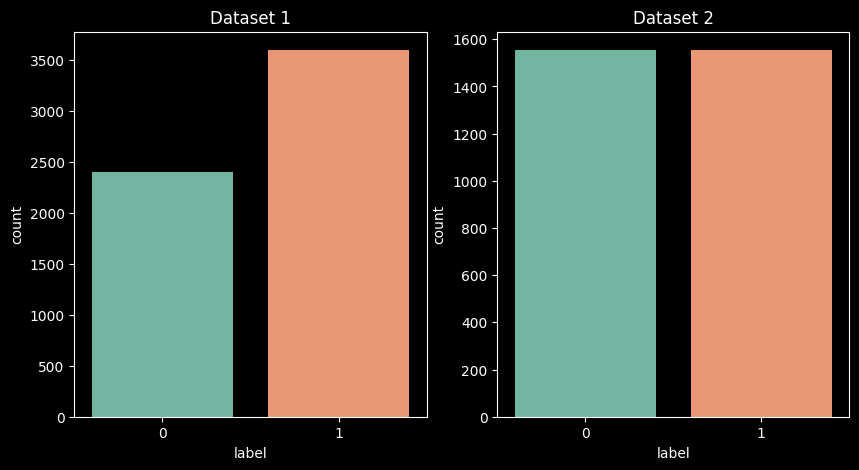

In [ ]:
#class imbalance
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(data=df, x='label', palette='Set2', ax=ax[0])
ax[0].set_title('Dataset 1')
sns.countplot(data=df_2, x='label', palette='Set2', ax=ax[1])
ax[1].set_title('Dataset 2')
plt.show()

In [ ]:
df = pd.concat([df, df_2], axis=0, ignore_index=True)
print("Joined Dataset shape: ", df.shape)
display(df.head())

Joined Dataset shape:  (9107, 2)


,query,label
0,What is the best way to study business managem...,1
1,What are the prerequisites for finance?,1
2,What are the latest news headlines?,0
3,What courses are available for learning hospit...,1
4,What are the latest news headlines?,0


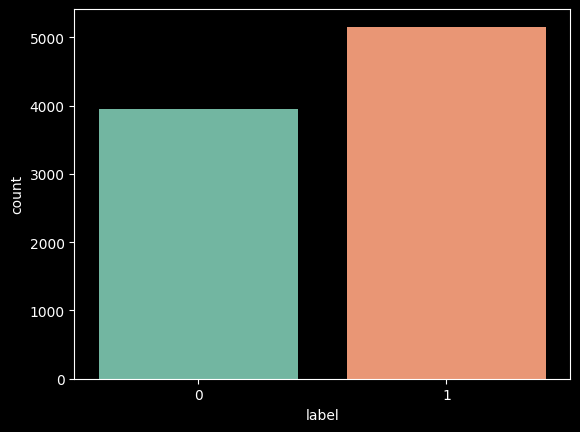

In [ ]:
sns.countplot(data=df, x='label', palette='Set2')
plt.show()

In [ ]:
#User Queries and labels
user_queries = df['query']
labels = df['label']
print(user_queries.shape)
print(labels.shape)

(9107,)
(9107,)


,mean,min,max
label,,,
0,9.035669,2,17
1,10.417734,7,20


------------------------------


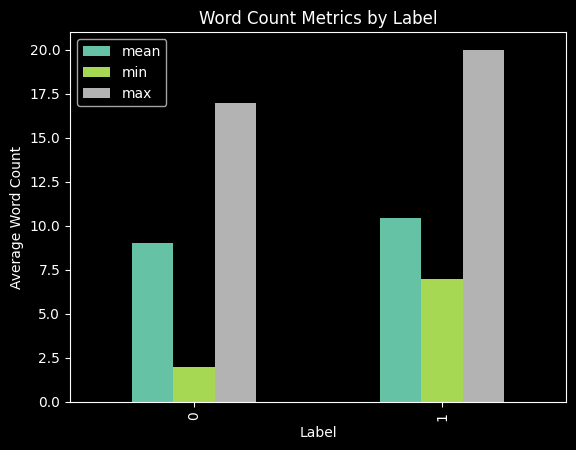

In [ ]:
def word_count(text):
  tokens = word_tokenize(text)
  return len(tokens)

# Apply the word_count function to the 'query' column and store the result in a new column
df['word_count'] = df['query'].apply(word_count)

g = df.groupby('label')['word_count'].agg(['mean', 'min', 'max'])
display(g)
print(dash_line)

# average wordcount by label
g.plot(kind='bar', color=plt.get_cmap('Set2', 3).colors)
plt.title('Word Count Metrics by Label')
plt.xlabel('Label')
plt.ylabel('Average Word Count')
plt.show()

## TfidVectorizer
1. Improved Relevance: TF-IDF helps in identifying the most relevant words in a document by reducing the impact of commonly used words2.
1. Better for Information Retrieval: It enhances the performance of search engines and recommendation systems by focusing on unique terms3.
1. Enhanced Text Classification: Models trained with TF-IDF features often perform better in tasks like sentiment analysis, topic modeling, and document clustering.

Case 1: Only Stopwords

In [ ]:
#TFIDF Vector
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(user_queries)
print(X_tfidf.shape)

(9107, 1114)


Case 2: Stemmer

In [ ]:
def tokenize_and_stem(text):
  stemmer = nltk.stem.PorterStemmer()
  tokens = word_tokenize(text)
  return [stemmer.stem(token) for token in tokens]

In [ ]:
#tfidf stop_words, stemmer
tfidf = TfidfVectorizer(stop_words='english', tokenizer=tokenize_and_stem, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(user_queries)
print(X_tfidf.shape)

(9107, 3842)


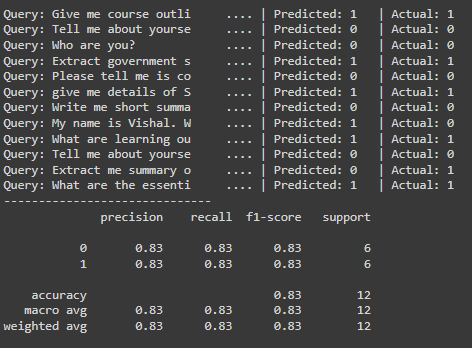

Case 3: Tokenizer: Lemmitizator

In [ ]:
#TFIDF Vector using Lemmatization
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]

In [ ]:
#tfidf stop_words, lemmatization, ngrams
tfidf = TfidfVectorizer(stop_words='english', tokenizer=LemmaTokenizer(), ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(user_queries)
print(X_tfidf.shape)

(9107, 3907)


## Training & testing

In [ ]:
#trai test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7285, 3907)
(1822, 3907)
(7285,)
(1822,)


In [ ]:
#models
model_nb = MultinomialNB()
model_lr = LogisticRegression()
model_svm = SVC()
model_rf = RandomForestClassifier()
model_xgb = xgb.XGBClassifier()

#model
models = [model_nb, model_lr, model_svm, model_rf, model_xgb]
model_names = ['Multinomial NB', 'Logistic Regression', 'Support Vector Machine', 'Random Forest', 'XGBoost']

#Evaluation Metrics
Kfold_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

#store metrics
model_metrics = {model_name: {'metrics': Kfold_metrics.copy(), 'train_time': 0} for model_name in model_names}

#KFold cv=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in zip(model_names, models):
  print(f'Model: {model_name}') #train each model

  start_time = time.time()
  for index, (train_index, validation_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_validation_fold = X_train[train_index], X_train[validation_index] #train
    y_train_fold, y_validation_fold = y_train.iloc[train_index], y_train.iloc[validation_index] #validation

    model.fit(X_train_fold, y_train_fold) #fit each model
    y_pred = model.predict(X_validation_fold) #predict each model

    #storing the metrics
    metrics = model_metrics[model_name].get('metrics')
    metrics.loc[index] = [accuracy_score(y_validation_fold, y_pred),
                                precision_score(y_validation_fold, y_pred),
                                recall_score(y_validation_fold, y_pred),
                                f1_score(y_validation_fold, y_pred)]
  end_time = time.time()
  print(f'Time taken: {end_time - start_time:.2f} seconds')
  model_metrics[model_name]['train_time'] = end_time - start_time
  print(dash_line)

Model: Multinomial NB
Time taken: 0.08 seconds
------------------------------
Model: Logistic Regression
Time taken: 0.16 seconds
------------------------------
Model: Support Vector Machine
Time taken: 3.25 seconds
------------------------------
Model: Random Forest
Time taken: 6.65 seconds
------------------------------
Model: XGBoost
Time taken: 3.71 seconds
------------------------------


In [ ]:
#Average metrics
for model_name, metrics in model_metrics.items():
  print(dash_line)
  print(f'Model: {model_name}')
  print(f'Train Time: {metrics["train_time"]:.2f} seconds')
  print(metrics.get('metrics').mean(axis=0).to_frame().T) #mean
  print(dash_line)

------------------------------
Model: Multinomial NB
Train Time: 0.08 seconds
   Accuracy  Precision  Recall  F1-Score
0       1.0        1.0     1.0       1.0
------------------------------
------------------------------
Model: Logistic Regression
Train Time: 0.16 seconds
   Accuracy  Precision  Recall  F1-Score
0       1.0        1.0     1.0       1.0
------------------------------
------------------------------
Model: Support Vector Machine
Train Time: 3.25 seconds
   Accuracy  Precision  Recall  F1-Score
0  0.999863    0.99976     1.0   0.99988
------------------------------
------------------------------
Model: Random Forest
Train Time: 6.65 seconds
   Accuracy  Precision    Recall  F1-Score
0  0.999863        1.0  0.999753  0.999877
------------------------------
------------------------------
Model: XGBoost
Train Time: 3.71 seconds
   Accuracy  Precision    Recall  F1-Score
0  0.999588        1.0  0.999272  0.999636
------------------------------


## Evaluation Metrics
In the context of a retrieval-augmented generation (RAG) system where you use a classification model to predict whether retrieval is necessary for a given query, the choice between precision, recall, and F1 score depends on your specific goals and the consequences of errors.

### Precision
Use Case: Precision is important if the cost of unnecessary retrievals (false positives) is high. For example, if retrieval is resource-intensive or time-consuming, you want to ensure that when the model predicts retrieval is necessary, it is indeed necessary.
Focus: High precision means fewer false positives, ensuring that most of the retrievals are relevant.
### Recall
Use Case: Recall is crucial if missing a necessary retrieval (false negative) has significant consequences. For instance, if failing to retrieve information leads to poor user experience or incomplete answers, you want to maximize recall.
Focus: High recall means fewer false negatives, ensuring that most necessary retrievals are performed.
### F1 Score
Use Case: The F1 score is useful when you need a balance between precision and recall. It is the harmonic mean of precision and recall, providing a single metric that considers both false positives and false negatives.
Focus: The F1 score is particularly useful when you need to balance the trade-offs between precision and recall, especially in cases where both false positives and false negatives are costly.
### Example Scenario
High Precision: If your system is designed to minimize unnecessary retrievals due to high computational costs, you would prioritize precision.
High Recall: If your system aims to ensure that all relevant information is retrieved to provide comprehensive answers, you would prioritize recall.
Balanced Approach: If both aspects are important, you would use the F1 score to find a balance.
In summary, if you want to ensure that retrievals are only performed when necessary, focus on precision. If you want to ensure that all necessary retrievals are performed, focus on recall. If you need a balance, use the F1 score

test set: (1822, 3907)


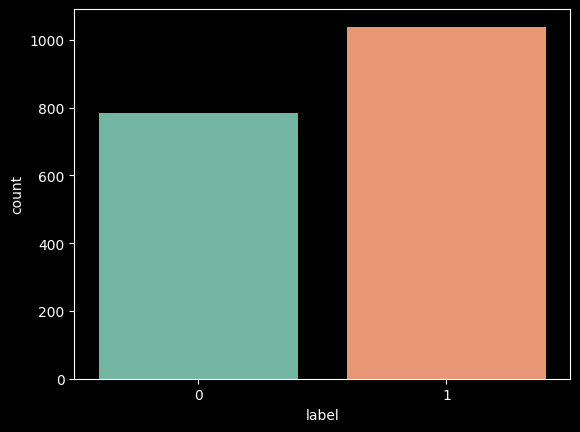

In [ ]:
#Test set
print(f'test set: {X_test.shape}')
sns.countplot(x=y_test, palette='Set2')
plt.show()

In [ ]:
#Final TestSet
for model_name, model in zip(model_names, models):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(dash_line)
  print(f'Model: {model_name}')
  print(f1_score(y_test, y_pred))
  print(dash_line)

------------------------------
Model: Multinomial NB
1.0
------------------------------
------------------------------
Model: Logistic Regression
1.0
------------------------------
------------------------------
Model: Support Vector Machine
1.0
------------------------------
------------------------------
Model: Random Forest
1.0
------------------------------
------------------------------
Model: XGBoost
0.9995189995189995
------------------------------


In [ ]:
#User Testing model
X_test_queries = ['Give me course outlines on Welding Technique program?',
                  'Tell me about yourself',
                  'Who are you?',
                  'Extract government standard for computer programming course?',
                  'Please tell me is coffee hot today?',
                  'give me details of Seasonal Management Program',
                  'Write me short summary on Environmental Well-being',
                  'My name is Vishal. What is my name?',
                  'What are learning outcomes for Hospitality and management course',
                  'Tell me about yourself? how can you help me assist in cirriculum generation',
                  'Extract me summary of Institutional Quality Assurance Process',
                  'What are the essential modules available in the Project Management Course']

#label
label = [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]

#prediction pipeline
pipe = Pipeline(steps=[
    ('tfidf', tfidf),
    ('model', model_rf)
  ]
)

y_pred = pipe.predict(X_test_queries)

#Evaluation
for query, pred, actual in zip(X_test_queries, y_pred, label):
    print(f'Query: {query[:20]:<25}.... | Predicted: {pred:<3} | Actual: {actual:<3}')

#
print(dash_line)
print(classification_report(label, y_pred))

Query: Give me course outli     .... | Predicted: 1   | Actual: 1  
Query: Tell me about yourse     .... | Predicted: 0   | Actual: 0  
Query: Who are you?             .... | Predicted: 0   | Actual: 0  
Query: Extract government s     .... | Predicted: 1   | Actual: 1  
Query: Please tell me is co     .... | Predicted: 0   | Actual: 0  
Query: give me details of S     .... | Predicted: 1   | Actual: 1  
Query: Write me short summa     .... | Predicted: 0   | Actual: 0  
Query: My name is Vishal. W     .... | Predicted: 0   | Actual: 0  
Query: What are learning ou     .... | Predicted: 1   | Actual: 1  
Query: Tell me about yourse     .... | Predicted: 0   | Actual: 0  
Query: Extract me summary o     .... | Predicted: 0   | Actual: 1  
Query: What are the essenti     .... | Predicted: 1   | Actual: 1  
------------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.83      0.91 

## Conclusion
1. ```Random forest Classifier``` out Performs other models ```['SVM', 'Multi-Nb', ...]``` with 92% accuracy
2. ```Lemmization``` improves the accuracy of rf model with\
  1. TD-idf params
  - stopwords `english`
  - n_grams (1, 2)